In [ ]:
#SETUP
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') 

[nltk_data] Downloading package punkt to /Users/animesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/animesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/animesh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
# Load datasets
train_data = pd.read_csv('TrainData.csv')
test_data = pd.read_csv('TestData.csv')

# Print the first few rows
print("Training Data Sample:")
print(train_data.head())

print("\nTest Data Sample:")
print(test_data.head())

# Check missing values
print("\nMissing values in train data:")
print(train_data.isnull().sum())

print("\nMissing values in test data:")
print(test_data.isnull().sum())

Training Data Sample:
   ArticleId                                               Text  Category
0       1429  sfa awaits report over mikoliunas the scottish...     sport
1       1896  parmalat to return to stockmarket parmalat  th...  business
2       1633  edu blasts arsenal arsenal s brazilian midfiel...     sport
3       2178  henman decides to quit davis cup tim henman ha...     sport
4        194  french suitor holds lse meeting european stock...  business

Test Data Sample:
   ArticleId                                               Text
0       1225  tobacco giants hail court ruling us tobacco co...
1       1576  soul sensation ready for awards south west tee...
2       1353  india and russia in energy talks india and rus...
3       1138  d arcy injury adds to ireland woe gordon d arc...
4       1915  labour plans maternity pay rise maternity pay ...

Missing values in train data:
ArticleId    0
Text         0
Category     0
dtype: int64

Missing values in test data:
ArticleId   

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


nltk.download('punkt')
nltk.download('stopwords')


dictionary = set()
try:
    with open('dictionary.txt', 'r') as file:
        dictionary = {line.strip() for line in file}
    print(f"Loaded {len(dictionary)} words into the dictionary.")
except FileNotFoundError:
    print("Dictionary file not found. Proceeding without it.")


stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, dictionary=None):
    """
    Cleans and preprocesses the text:
    - Converts text to lowercase
    - Removes punctuation & numbers
    - Tokenizes
    - Removes stopwords
    - Stems words
    - Keeps words that exist in the dictionary (if provided)
    """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  
    text = re.sub(r'\d+', '', text)  
    tokens = word_tokenize(text)


    filtered_tokens = [word for word in tokens if word not in stop_words]


    processed_words = [
        stemmer.stem(word) for word in filtered_tokens if not dictionary or word in dictionary
    ]

    return ' '.join(processed_words)



train_data["Preprocessed_Text"] = train_data["Text"].apply(lambda x: preprocess_text(x, dictionary))
test_data["Preprocessed_Text"] = test_data["Text"].apply(lambda x: preprocess_text(x, dictionary))


train_data.to_csv("preprocessed_train.csv", index=False)
test_data.to_csv("preprocessed_test.csv", index=False)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(train_data["Preprocessed_Text"])
y = train_data["Category"].astype('category').cat.codes 


np.save("X.npy", X.toarray())
np.save("y.npy", y)


with open("tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(vectorizer, file)

print("Preprocessing Complete! Data saved successfully.")


[nltk_data] Downloading package punkt to /Users/animesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/animesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loaded 1000 words into the dictionary.
Preprocessing Complete! Data saved successfully.


Step 2.1 (Evaluating the Decision Tree Model)

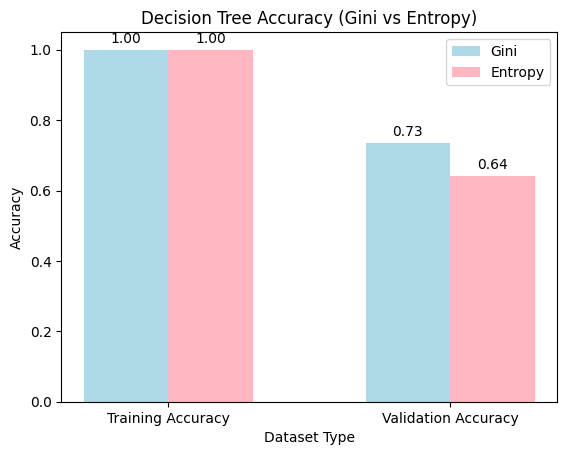

 Decision Tree Evaluation Complete!
Gini - Training Accuracy: 1.0000, Validation Accuracy: 0.7350
Entropy - Training Accuracy: 1.0000, Validation Accuracy: 0.6400


In [18]:

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = np.load("X.npy")
y = np.load("y.npy")

# Spliting the dataset into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


dt_gini = DecisionTreeClassifier(criterion="gini", random_state=42)
dt_entropy = DecisionTreeClassifier(criterion="entropy", random_state=42)

# Training
dt_gini.fit(X_train, y_train)
dt_entropy.fit(X_train, y_train)

# Making predictions
y_train_pred_gini = dt_gini.predict(X_train)
y_val_pred_gini = dt_gini.predict(X_val)

y_train_pred_entropy = dt_entropy.predict(X_train)
y_val_pred_entropy = dt_entropy.predict(X_val)

# Accuracy Calculations
train_accuracy_gini = accuracy_score(y_train, y_train_pred_gini)
val_accuracy_gini = accuracy_score(y_val, y_val_pred_gini)

train_accuracy_entropy = accuracy_score(y_train, y_train_pred_entropy)
val_accuracy_entropy = accuracy_score(y_val, y_val_pred_entropy)

# Plotting Accuracy
labels = ["Training Accuracy", "Validation Accuracy"]
gini_scores = [train_accuracy_gini, val_accuracy_gini]
entropy_scores = [train_accuracy_entropy, val_accuracy_entropy]

x = np.arange(len(labels))
width = 0.3  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, gini_scores, width, label='Gini', color='lightblue')
bars2 = ax.bar(x + width/2, entropy_scores, width, label='Entropy', color='lightpink')


ax.set_xlabel("Dataset Type")
ax.set_ylabel("Accuracy")
ax.set_title("Decision Tree Accuracy (Gini vs Entropy)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()

print(f" Decision Tree Evaluation Complete!")
print(f"Gini - Training Accuracy: {train_accuracy_gini:.4f}, Validation Accuracy: {val_accuracy_gini:.4f}")
print(f"Entropy - Training Accuracy: {train_accuracy_entropy:.4f}, Validation Accuracy: {val_accuracy_entropy:.4f}")


Step 2.2: Evaluating Decision Tree using 5-Fold Cross-Validation on min_samples_leaf and Reporting Training & Testing Accuracy

   min_samples_leaf  training_accuracy_mean  training_accuracy_std  \
0                10                 0.82275               0.007306   
1                50                 0.64800               0.013684   
2               100                 0.48125               0.021679   
3               200                 0.38225               0.010530   

   testing_accuracy_mean  testing_accuracy_std  
0                  0.694              0.020347  
1                  0.605              0.016432  
2                  0.451              0.035833  
3                  0.358              0.018330  


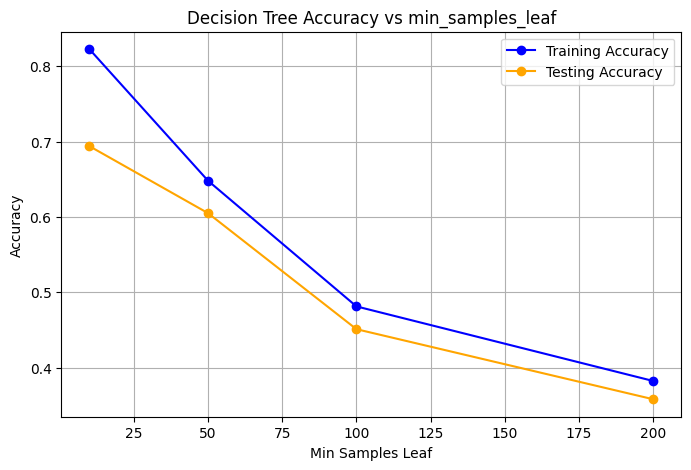

In [ ]:

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate


min_samples_leaf_values = [10, 50, 100, 200]

# Store results
results = []


for min_samples in min_samples_leaf_values:
    dt_model = DecisionTreeClassifier(criterion="gini", min_samples_leaf=min_samples, random_state=42)
    

    cv_results = cross_validate(dt_model, X, y, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)
    

    results.append({
        "min_samples_leaf": min_samples,
        "training_accuracy_mean": np.mean(cv_results["train_score"]),
        "training_accuracy_std": np.std(cv_results["train_score"]),
        "testing_accuracy_mean": np.mean(cv_results["test_score"]),
        "testing_accuracy_std": np.std(cv_results["test_score"]),
    })


results_df = pd.DataFrame(results)


print(results_df)


plt.figure(figsize=(8, 5))
plt.plot(results_df["min_samples_leaf"], results_df["training_accuracy_mean"], '-o', label="Training Accuracy", color='blue')
plt.plot(results_df["min_samples_leaf"], results_df["testing_accuracy_mean"], '-o', label="Testing Accuracy", color='orange')


plt.xlabel("Min Samples Leaf")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy vs min_samples_leaf")
plt.legend()
plt.grid(True)
plt.show()

Step 2.3: Evaluating Decision Tree using 5-Fold Cross-Validation on max_features


Decision Tree Cross-Validation Results (max_features):
 max_features  training_accuracy_mean  training_accuracy_std  testing_accuracy_mean  testing_accuracy_std
          0.2                     1.0                    0.0                  0.694              0.043058
          0.4                     1.0                    0.0                  0.727              0.036824
          0.6                     1.0                    0.0                  0.722              0.020881
          0.8                     1.0                    0.0                  0.734              0.012806
          1.0                     1.0                    0.0                  0.717              0.020149


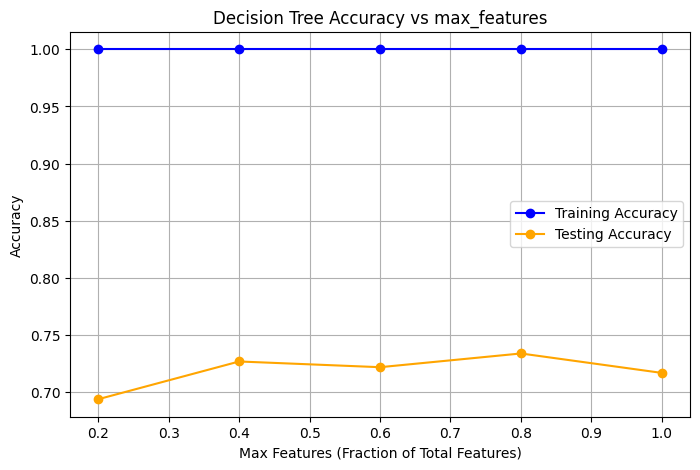

In [ ]:

from sklearn.model_selection import cross_validate

max_features_values = [0.2, 0.4, 0.6, 0.8, 1.0]  

results = []


for max_feat in max_features_values:
    dt_model = DecisionTreeClassifier(criterion="gini", max_features=max_feat, random_state=42)
    

    cv_results = cross_validate(dt_model, X, y, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)
    

    results.append({
        "max_features": max_feat,
        "training_accuracy_mean": np.mean(cv_results["train_score"]),
        "training_accuracy_std": np.std(cv_results["train_score"]),
        "testing_accuracy_mean": np.mean(cv_results["test_score"]),
        "testing_accuracy_std": np.std(cv_results["test_score"]),
    })


results_df = pd.DataFrame(results)

# Print results
print("\nDecision Tree Cross-Validation Results (max_features):")
print(results_df.to_string(index=False))


results_df.to_csv("dt_results_max_features.csv", index=False)

# Plot Training & Testing Accuracy
plt.figure(figsize=(8, 5))
plt.plot(results_df["max_features"], results_df["training_accuracy_mean"], '-o', label="Training Accuracy", color='blue')
plt.plot(results_df["max_features"], results_df["testing_accuracy_mean"], '-o', label="Testing Accuracy", color='orange')


plt.xlabel("Max Features (Fraction of Total Features)")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy vs max_features")
plt.legend()
plt.grid(True)
plt.show()


Step 3.1: Describing Random Forest Classifier Parameter Settings

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "n_estimators": 100,        
    "criterion": "gini",       
    "max_depth": None,       
    "min_samples_split": 2,      
    "min_samples_leaf": 1,       
    "max_features": "sqrt",      
    "bootstrap": True,           
    "random_state": 42           
}


print("\nRandom Forest Hyperparameters:")
for param, value in rf_params.items():
    print(f"{param}: {value}")


rf_model = RandomForestClassifier(**rf_params)

print("\nRandom Forest Model Initialized with Above Parameters.")



Random Forest Hyperparameters:
n_estimators: 100
criterion: gini
max_depth: None
min_samples_split: 2
min_samples_leaf: 1
max_features: sqrt
bootstrap: True
random_state: 42

Random Forest Model Initialized with Above Parameters.


Step 3.2: Evaluating Random Forest Model using 5-Fold Cross-Validation on n_estimators (Number of Trees)


Random Forest Cross-Validation Results (n_estimators):
 n_estimators  training_accuracy_mean  training_accuracy_std  testing_accuracy_mean  testing_accuracy_std
           10                  0.9975               0.001581                  0.820              0.026646
           50                  1.0000               0.000000                  0.906              0.022226
          100                  1.0000               0.000000                  0.924              0.031528
          200                  1.0000               0.000000                  0.931              0.028705
          300                  1.0000               0.000000                  0.931              0.033076


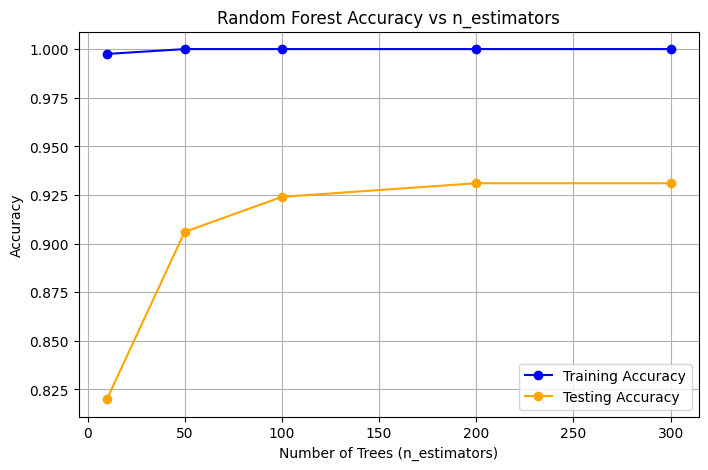

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate


n_estimators_values = [10, 50, 100, 200, 300] 


results = []

# Perform 5-Fold Cross-Validation for each n_estimators value
for n_trees in n_estimators_values:
    rf_model = RandomForestClassifier(n_estimators=n_trees, criterion="gini", random_state=42, n_jobs=-1)
    

    cv_results = cross_validate(rf_model, X, y, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)
    
    # Store results
    results.append({
        "n_estimators": n_trees,
        "training_accuracy_mean": np.mean(cv_results["train_score"]),
        "training_accuracy_std": np.std(cv_results["train_score"]),
        "testing_accuracy_mean": np.mean(cv_results["test_score"]),
        "testing_accuracy_std": np.std(cv_results["test_score"]),
    })


results_df = pd.DataFrame(results)

# Print results
print("\nRandom Forest Cross-Validation Results (n_estimators):")
print(results_df.to_string(index=False))


results_df.to_csv("rf_results_n_estimators.csv", index=False)

# Plot Training & Testing Accuracy
plt.figure(figsize=(8, 5))
plt.plot(results_df["n_estimators"], results_df["training_accuracy_mean"], '-o', label="Training Accuracy", color='blue')
plt.plot(results_df["n_estimators"], results_df["testing_accuracy_mean"], '-o', label="Testing Accuracy", color='orange')


plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs n_estimators")
plt.legend()
plt.grid(True)
plt.show()


Step 3.3: Evaluating Random Forest Model using 5-Fold Cross-Validation on min_samples_leaf


Random Forest Cross-Validation Results (min_samples_leaf):
 min_samples_leaf  training_accuracy_mean  training_accuracy_std  testing_accuracy_mean  testing_accuracy_std
                1                 1.00000               0.000000                  0.924              0.031528
                5                 0.97575               0.003758                  0.916              0.028879
               10                 0.95000               0.003791                  0.911              0.027276
               20                 0.91275               0.010350                  0.869              0.021541
               50                 0.57800               0.025466                  0.524              0.025179
              100                 0.28900               0.023709                  0.285              0.024495


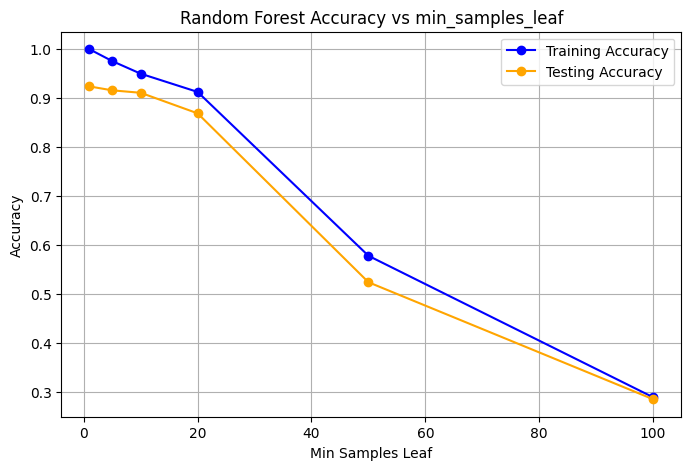

In [ ]:

min_samples_leaf_values = [1, 5, 10, 20, 50, 100]

# Store results
results = []


for min_samples in min_samples_leaf_values:
    rf_model = RandomForestClassifier(n_estimators=100, criterion="gini", min_samples_leaf=min_samples, random_state=42, n_jobs=-1)
    

    cv_results = cross_validate(rf_model, X, y, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)
    

    results.append({
        "min_samples_leaf": min_samples,
        "training_accuracy_mean": np.mean(cv_results["train_score"]),
        "training_accuracy_std": np.std(cv_results["train_score"]),
        "testing_accuracy_mean": np.mean(cv_results["test_score"]),
        "testing_accuracy_std": np.std(cv_results["test_score"]),
    })


results_df = pd.DataFrame(results)


print("\nRandom Forest Cross-Validation Results (min_samples_leaf):")
print(results_df.to_string(index=False))


results_df.to_csv("rf_results_min_samples_leaf.csv", index=False)


plt.figure(figsize=(8, 5))
plt.plot(results_df["min_samples_leaf"], results_df["training_accuracy_mean"], '-o', label="Training Accuracy", color='blue')
plt.plot(results_df["min_samples_leaf"], results_df["testing_accuracy_mean"], '-o', label="Testing Accuracy", color='orange')


plt.xlabel("Min Samples Leaf")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs min_samples_leaf")
plt.legend()
plt.grid(True)
plt.show()


Step 4: Predicting Labels for Testing Data

In [ ]:
import pickle
from sklearn.ensemble import RandomForestClassifier


test_data = pd.read_csv("preprocessed_test.csv")


with open("tfidf_vectorizer.pkl", "rb") as file:
    vectorizer = pickle.load(file)


X_test = vectorizer.transform(test_data["Preprocessed_Text"])


best_rf_model = RandomForestClassifier(n_estimators=200, criterion="gini", min_samples_leaf=10, random_state=42)
best_rf_model.fit(np.load("X.npy"), np.load("y.npy"))  

# Predict Labels for Test Data
y_test_pred = best_rf_model.predict(X_test)

category_mapping = {
    0: "sport",
    1: "business",
    2: "tech",
    3: "entertainment",
    4: "politics"
}


y_test_pred_labels = [category_mapping[label] for label in y_test_pred]


labels_file = "labels.csv"
test_data["Predicted_Label"] = y_test_pred_labels
test_data[["ArticleId", "Predicted_Label"]].to_csv(labels_file, index=False, header=False)

print(f"Predictions Saved in {labels_file} ")


✅ Predictions Saved in labels.csv 
